In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pylab as pylab
%matplotlib inline
import datetime
import requests
import statsmodels.api as sm
from scipy.stats import kruskal, mannwhitneyu

C:\Users\georg\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
pd.set_option('max_columns',500)
pd.set_option('max_rows',500)
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (5, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

# 2 Dataset

In [4]:
in_folder = '../data/raw/' 

df = pd.read_csv( in_folder + 'listings.csv')

C:\Users\georg\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (61,62,95) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df.shape

(20769, 106)

In [6]:
orig_num_rows = df.shape[0]
orig_num_rows

20769

# 3 Data Cleaning and Wrangling

## 3.1 Data Type Correction

In [7]:
#String to numeric

col_to_numeric = ['price','security_deposit','cleaning_fee','extra_people']

for col in col_to_numeric:
    df[col] = df[col].str.replace('$','').str.replace(',','').astype(float)

df.host_response_rate = df.host_response_rate.str.replace('%','').astype(float)/100

#String to datetime

col_to_datetime = ['last_scraped','host_since','calendar_last_scraped','first_review','last_review']

for col in col_to_datetime:
    df[col] = pd.to_datetime(df[col])

## 3.2 Incorrect Price Data Elimination

In [8]:
#Number of listings with price = 0
num_of_zeroes = df[df.price == 0].shape[0]
num_of_zeroes

4

In [9]:
# Remove listings with price == 0
df = df[df.price > 0]
# Check if listings removed
assert df[df.price == 0].shape[0] == 0
assert df.shape[0] == (orig_num_rows - num_of_zeroes)

In [10]:
df.shape

(20765, 106)

## 3.3 Missing Values Imputation

In [11]:
size = df.shape[0]
missing_cnt = df.isnull().sum()
missing_pct = missing_cnt/size*100
df_missing = pd.concat([missing_cnt,missing_pct],axis=1)
df_missing.columns = ['Missing Count','Missing Percentage']
df_missing[df_missing['Missing Count']>0].sort_values('Missing Count', ascending=False)

,Missing Count,Missing Percentage
thumbnail_url,20765,100.000000
medium_url,20765,100.000000
host_acceptance_rate,20765,100.000000
neighbourhood_group_cleansed,20765,100.000000
xl_picture_url,20765,100.000000
jurisdiction_names,20763,99.990368
license,20761,99.980737
square_feet,20609,99.248736
monthly_price,18987,91.437515
weekly_price,18678,89.949434


In [12]:
# Save to csv file for report
out_folder = '../data/interim/'
df_missing[df_missing['Missing Count']>0].sort_values('Missing Count', 
                                                      ascending=False).to_csv(out_folder + 'missing_summary.csv')

In [13]:
#Numeric Features (1)
for col in ['host_listings_count','bathrooms','host_response_rate','bedrooms','beds']:
    df[col+'_NA'] = np.where(df[col].isnull(),1, 0)
    m = df[col].median()
    df[col].fillna(m,inplace=True)
    
#Numeric Features (2)
for col in ['security_deposit','cleaning_fee']:
    df[col+'_NA'] = np.where(df[col].isnull(),1, 0)
    df[col].fillna(0,inplace=True)
    
#Numeric Features (3)
for col in ['review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin',
           'review_scores_communication','review_scores_location','review_scores_value','reviews_per_month']:
    df[col+'_NA'] = np.where(df[col].isnull(),1, 0)
    df[col].fillna(df[col].median(),inplace=True)

In [14]:
#Categorical Features
# for col in ['host_response_time', 'host_is_superhost','host_identity_verified','host_has_profile_pic']:

#     df[col+"_NA"] = np.where(df[col].isnull(),1,0)
#     df[col].fillna(df[col].mode().iloc[0],inplace=True)

for col in ['host_response_time', 'host_is_superhost','host_identity_verified','host_has_profile_pic']:
    df[col].fillna('missing',inplace=True)

In [15]:
#Datetime Features
for col in ['host_since', 'first_review', 'last_review']:
    df[col+"_NA"] = np.where(df[col].isnull(),1,0)
    df[col].fillna(df[col].quantile(0.5),inplace=True)

## 3.4 New Feature Creation


### 3.4.1 City Names

In [16]:
# Existing city information
df.neighbourhood.nunique(), df.neighbourhood_cleansed.nunique()

(140, 140)

In [17]:
# Create new column for FSA
df['fsa'] = df.zipcode.str.slice(stop=3).str.upper()

In [18]:
# read in fsa-city data (Wikipedia)
in_folder = '../data/external/'
toronto_fsa = pd.read_csv(in_folder + 'toronto_fsa.csv')

#create a dictionary with postcode as key and borough (city) as dictionary
fsa_dict = {i:j for i,j in zip(toronto_fsa.Postcode, toronto_fsa.Borough)}

#create new column that maps the FSA to the city name
df['city_fsa'] = np.nan
df['city_fsa'] = df.fsa.map(fsa_dict)

In [19]:
df.city_fsa.value_counts(dropna=False)

Downtown Toronto    7938
West Toronto        3359
North York          2748
Central Toronto     1426
Scarborough         1358
Etobicoke           1083
East Toronto        1069
York                 707
East York            671
NaN                  376
Thornhill             20
Pickering              2
Not assigned           2
Mississauga            2
Markham                1
Kleinburg              1
Guelph                 1
Queen's Park           1
Name: city_fsa, dtype: int64

In [20]:
# Create a list of indexes for unknown
idx_nan = df.loc[df.city_fsa.isnull() == True].index

# Create list of "Not assigned"
idx_not_assigned = df.loc[df.city_fsa == 'Not assigned'].index

# Create list of rare cities to confirm location with mapquest api
#set threshold to be 1% of all data

threshold = df.shape[0] * 0.01
rare_city_list = df.city_fsa.value_counts()[df.city_fsa.value_counts() < threshold].index
idx_rare = df.loc[df.city_fsa.apply(lambda x: x in rare_city_list)].index

In [21]:
rare_city_list

Index(['Thornhill', 'Not assigned', 'Mississauga', 'Pickering', 'Markham',
       'Kleinburg', 'Queen's Park', 'Guelph'],
      dtype='object')

In [22]:
idx_set = set()
for idx in [idx_nan,idx_not_assigned,idx_rare]:
    idx_set.update(idx)

#convert to list so the order is consistent
idx_list = list(idx_set)

#check listings count
print('Number of listings with unknown FSA or FSA in rare cities is:')
len(idx_list)

Number of listings with unknown FSA or FSA in rare cities is:


406

**Below: Retrieve data from mapquest; performed in milestone report data preparation (not in final report prep)**

In [23]:
##Use Mapquest API
##Only run once on the first run

##key hidden for security reasons

# api_key = "***"

# lat_list = []
# lon_list= []
# fsa_list = []

# for idx in idx_list:
#     lat = df.loc[idx].latitude
#     lon = df.loc[idx].longitude
#     url = "http://www.mapquestapi.com/geocoding/v1/reverse?key=" + api_key + "&location=" + str(lat) + "," + str(lon)
#     r = requests.get(url)
#     fsa = r.json()['results'][0]['locations'][0]['postalCode'][:3]
#     lat_list.append(lat)
#     lon_list.append(lon)
#     fsa_list.append(fsa)

In [24]:
# city_rev_geocode_df = pd.DataFrame({'latitude':lat_list,'longitude':lon_list,'fsa':fsa_list},index=idx_list)
# city_rev_geocode_df['city'] = np.nan
# city_rev_geocode_df['city'] = city_rev_geocode_df.fsa.map(fsa_dict)

# out_folder = '../data/external/'
# city_rev_geocode_df.to_csv(out_folder + '/city_rev_geocode_df.csv')

In [25]:
file = '../data/external/city_rev_geocode_df.csv'
city_rev_geocode_df = pd.read_csv(file, index_col=0)

In [26]:
city_rev_geocode_df.head()


,fsa,latitude,longitude,city
4107,M9V,43.73904,-79.56083,Etobicoke
14348,M2N,43.75700,-79.40379,North York
16397,M5J,43.64257,-79.37754,Downtown Toronto
4112,M5J,43.64489,-79.38469,Downtown Toronto
12309,M4Y,43.66479,-79.37691,Downtown Toronto


In [27]:
city_rev_geocode_df.city.value_counts(dropna=False)

Downtown Toronto    200
North York           48
West Toronto         48
Etobicoke            23
Central Toronto      22
Scarborough          18
East Toronto         18
York                  8
East York             7
Thornhill             7
Mississauga           2
Pickering             2
NaN                   2
Markham               1
Name: city, dtype: int64

In [28]:
city_rev_geocode_df.shape[0]

406

In [29]:
#impute df city_fsa information with api collected data

for idx in city_rev_geocode_df.index:
    df.loc[idx,'fsa'] = city_rev_geocode_df.loc[idx,'fsa']
    df.loc[idx,'city_fsa'] = city_rev_geocode_df.loc[idx,'city']

In [30]:
df.city_fsa.value_counts(dropna=False)

Downtown Toronto    8138
West Toronto        3407
North York          2796
Central Toronto     1448
Scarborough         1376
Etobicoke           1106
East Toronto        1087
York                 715
East York            678
Thornhill              7
Pickering              2
Mississauga            2
NaN                    2
Markham                1
Name: city_fsa, dtype: int64

In [31]:
#Drop Minority City
city_list = ['Downtown Toronto','Central Toronto','East Toronto','West Toronto','York','North York','East York','Scarborough','Etobicoke']
city_filter = df.city_fsa.apply(lambda x: x in city_list)
df = df.loc[city_filter]

In [32]:
df.shape[0]

20751

In [33]:
df.city_fsa.value_counts(normalize=True)

Downtown Toronto    0.392174
West Toronto        0.164185
North York          0.134740
Central Toronto     0.069780
Scarborough         0.066310
Etobicoke           0.053299
East Toronto        0.052383
York                0.034456
East York           0.032673
Name: city_fsa, dtype: float64

### 3.4.2 Indicator Variable for Amenities

In [34]:
df['amenities_list'] = df['amenities'].str.lower().str.replace("[{}’\"]",'').str.split(',')
amenities_set = set()
for i in df['amenities_list']:
    amenities_set.update(i)
amenities_set.remove('')
for item in amenities_set:
    df[item] = df.amenities_list.apply(lambda x: 1 if item in x else 0)

In [35]:
amenities_set

{' toilet',
 '24-hour check-in',
 'accessible-height bed',
 'accessible-height toilet',
 'air conditioning',
 'air purifier',
 'alfresco bathtub',
 'amazon echo',
 'baby bath',
 'baby monitor',
 'babysitter recommendations',
 'balcony',
 'bath towel',
 'bathroom essentials',
 'bathtub',
 'bathtub with bath chair',
 'bbq grill',
 'beach essentials',
 'beach view',
 'beachfront',
 'bed linens',
 'bedroom comforts',
 'bidet',
 'body soap',
 'breakfast',
 'breakfast table',
 'brick oven',
 'building staff',
 'buzzer/wireless intercom',
 'cable tv',
 'carbon monoxide detector',
 'cat(s)',
 'ceiling fan',
 'ceiling hoist',
 'central air conditioning',
 'changing table',
 'childrens books and toys',
 'childrens dinnerware',
 'cleaning before checkout',
 'coffee maker',
 'convection oven',
 'cooking basics',
 'crib',
 'day bed',
 'disabled parking spot',
 'dishes and silverware',
 'dishwasher',
 'dog(s)',
 'doorman',
 'double oven',
 'dryer',
 'dvd player',
 'electric profiling bed',
 'elevato

In [36]:
len(amenities_set)

196

In [37]:
size = df.shape[0]
count = []
pct = []
for item in amenities_set:
    count.append(df[item].sum())
    pct.append(df[item].sum()/size*100)
amenities_counts = pd.DataFrame({'Count':count,"Percentage of Listings":pct},index = amenities_set).sort_values(by='Count')

In [38]:
# save to file for report
out_folder = '../data/interim/'
amenities_counts.to_csv(out_folder + 'amenities_count.csv')

In [39]:
#Rarest Amenities
amenities_counts.head()

,Count,Percentage of Listings
brick oven,1,0.004819
hammock,1,0.004819
tennis court,1,0.004819
pool toys,1,0.004819
alfresco bathtub,2,0.009638


In [40]:
#Most Common Amenities
amenities_counts.tail()

,Count,Percentage of Listings
kitchen,19127,92.173871
smoke detector,19520,94.067756
essentials,19736,95.108669
heating,20091,96.819430
wifi,20366,98.144668


In [41]:
amenities_counts.loc['hot water']

Count                     12253.000000
Percentage of Listings       59.047757
Name: hot water, dtype: float64

In [42]:
# remove amenities list feature here
df.drop('amenities_list', axis=1,inplace=True)

### 3.4.3 Verification Count

In [43]:
df['host_verification_sum']=df.host_verifications.apply(lambda x: len(x.strip('[]').split(', ')))

### 3.4.4 Days since events

In [44]:
ref_date = datetime.datetime(2019,6,27)

In [45]:
dt_col = ['host_since','first_review','last_review']
for col in dt_col:
    df['days_since'+col] = df[col].apply(lambda x: (ref_date - x).days)

# 4 Data Exploration

## 4.1 Price

In [46]:
df.price.describe()

count    20751.000000
mean       143.349766
std        234.243598
min         13.000000
25%         64.000000
50%        101.000000
75%        160.000000
max      13422.000000
Name: price, dtype: float64

In [47]:
df.loc[df.price == 13422, 'listing_url']

6263    https://www.airbnb.com/rooms/16039481
Name: listing_url, dtype: object

In [48]:
# Create price cutoff as 99th percentile of price data
price_cap = np.percentile(df.price, 99)
price_cap

750.0

In [49]:
#cap price and check
df = df[df.price <= price_cap]
df.price.describe()

count    20544.000000
mean       129.919782
std        100.365287
min         13.000000
25%         64.000000
50%        101.000000
75%        159.000000
max        750.000000
Name: price, dtype: float64

In [50]:
df['log_price'] = np.log(df.price)

In [51]:
out_folder = '../reports/final_report_figures/'

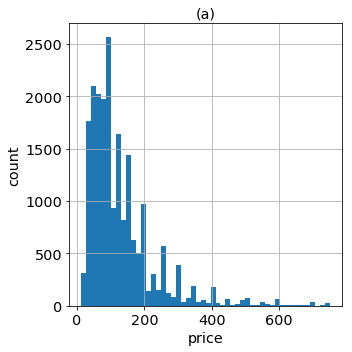

In [52]:
df.price.hist(bins=50)
plt.xlabel('price')
plt.ylabel('count')
plt.title('(a)');
plt.tight_layout();
plt.savefig(out_folder + "price_hist.png")

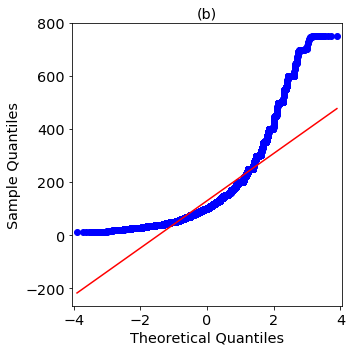

In [53]:
sm.qqplot(df.price,line='r')
plt.title('(b)')
plt.tight_layout()
plt.savefig(out_folder + 'price_QQ')

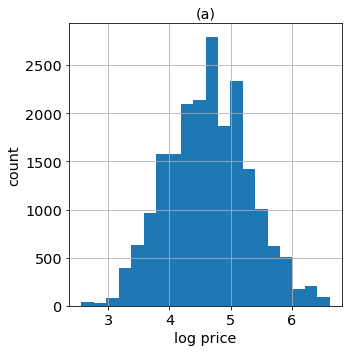

In [54]:
df.log_price.hist(bins=20)
plt.xlabel('log price')
plt.ylabel('count')
plt.title('(a)');
plt.tight_layout();
plt.savefig(out_folder + "log_price_hist.png")

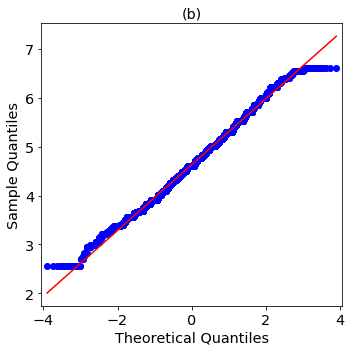

In [55]:
sm.qqplot(df.log_price,line='r')
plt.title('(b)')
plt.tight_layout()
plt.savefig(out_folder + 'log_price_QQ.png')

## 4.2 Geographical Information

In [56]:
df.city_fsa.value_counts(dropna=False)

Downtown Toronto    8026
West Toronto        3385
North York          2772
Central Toronto     1422
Scarborough         1370
Etobicoke           1102
East Toronto        1081
York                 712
East York            674
Name: city_fsa, dtype: int64

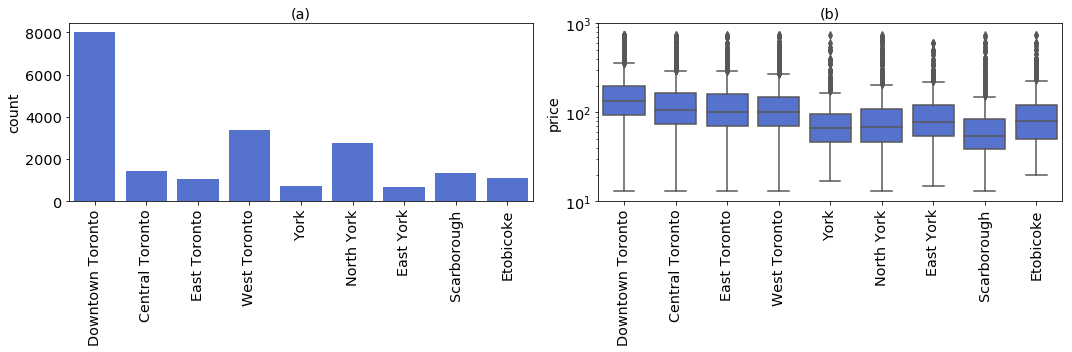

In [57]:
city_order = ['Downtown Toronto','Central Toronto','East Toronto','West Toronto','York','North York','East York',
              'Scarborough','Etobicoke']
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(data=df,x='city_fsa',order=city_order,color='royalblue')
plt.xlabel("")
plt.xticks(rotation=90)
plt.title('(a)')
plt.subplot(1,2,2)
sns.boxplot(data=df, x='city_fsa',y='price', order=city_order,color='royalblue')
plt.yscale('log')
plt.ylim([10,1000])
plt.xlabel("")
plt.ylabel("price")
plt.xticks(rotation=90)
plt.title('(b)')
plt.tight_layout()
plt.savefig(out_folder + "region.png");

## 4.3 Property Information

### 4.3.1 Property Type

In [58]:
# Create a function for count and percentage for categorical variables

def count_pct(variable, data=df):
    idx = data[variable].value_counts().index
    count_pct_dict = {'count': data[variable].value_counts(dropna=False).values,
                      'pct':data[variable].value_counts(dropna=False).values/data.shape[0]*100}
    return pd.DataFrame(count_pct_dict,index=idx)

In [59]:
property_type_counts = count_pct(variable = 'property_type')
property_type_counts

,count,pct
Apartment,6123,29.804322
Condominium,5441,26.484618
House,5415,26.358061
Townhouse,954,4.643692
Guest suite,795,3.869743
Bungalow,675,3.285631
Loft,439,2.136877
Serviced apartment,215,1.046534
Guesthouse,109,0.530569
Bed and breakfast,102,0.496495


In [60]:
len(df.property_type.unique()), (property_type_counts['count'] <= 10).sum()

(30, 16)

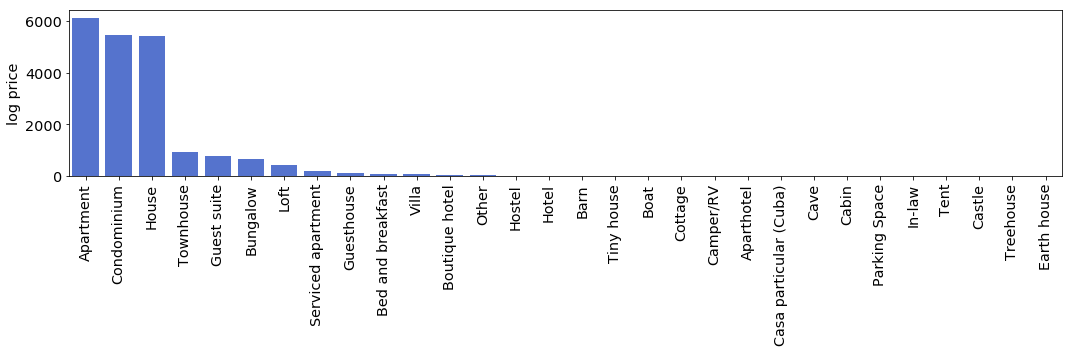

In [61]:
# create and index so for ordering the boxplots according to counts
plt.figure(figsize=(15,5))

idx = df.property_type.value_counts().index
sns.countplot(data=df, x='property_type', order=idx,color='royalblue')
#plt.xlabel("property type")
plt.ylabel('log price')
plt.xticks(rotation=90)
plt.xlabel('')
plt.tight_layout()
plt.savefig(out_folder + "bar_property_type.png");

In [62]:
# Assign Bungalow as House per Wikipedia
df.loc[df.property_type == 'Bungalow','property_type'] = 'House'

In [63]:
# Assign Other to minority property types

threshold = 0.05
size = df.shape[0]
filter_ = df.property_type.value_counts() > threshold * size
property_type_included = df.property_type.value_counts()[filter_].index
df['property_type_simple'] = df.property_type.apply(lambda x: 'Other' if x not in property_type_included else x)

''

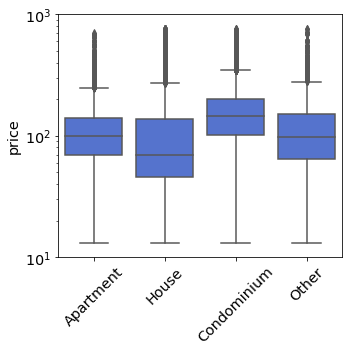

In [64]:
order = df['property_type_simple'].value_counts().index

plt.figure(figsize=(5,5))
sns.boxplot(data=df, x='property_type_simple',y='price', order=order,color='royalblue')
plt.xlabel("")
plt.ylabel("price")
plt.yscale('log')
plt.ylim([10,1000])
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(out_folder + "property_type_box.png")
;

### 4.3.2 Room Type

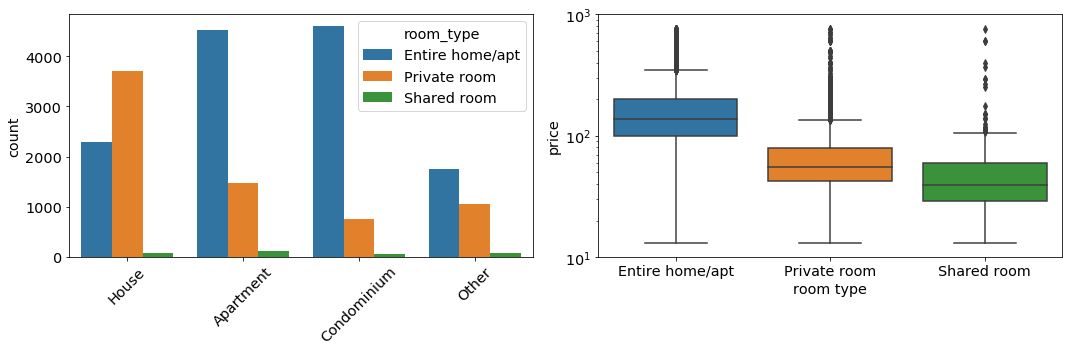

In [65]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(data=df, x='property_type_simple',hue='room_type')
plt.xlabel('')
plt.ylabel('count')
plt.xticks(rotation=45)
plt.subplot(1,2,2)
sns.boxplot(data=df,y='price',x='room_type')
plt.xlabel('room type')
plt.ylabel('price')
plt.yscale('log')
plt.ylim([10,1000])
plt.tight_layout()
plt.savefig(out_folder + "room_type_bar_box.png");

### 4.3.3 Property Features

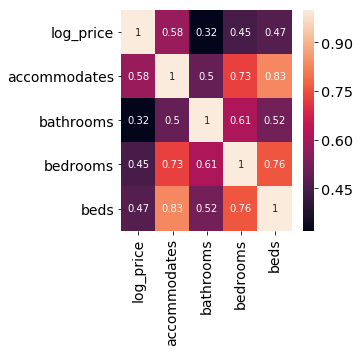

In [66]:
plt.figure(figsize=(5,5))
corr_matrix = df[['log_price','accommodates', 'bathrooms', 'bedrooms', 'beds']].corr().round(2)
sns.heatmap(corr_matrix, annot=True)
plt.tick_params(labelsize=14)
plt.tight_layout()
plt.savefig(out_folder + 'corr_matrix_features.png');

### 4.3.4 Amenities

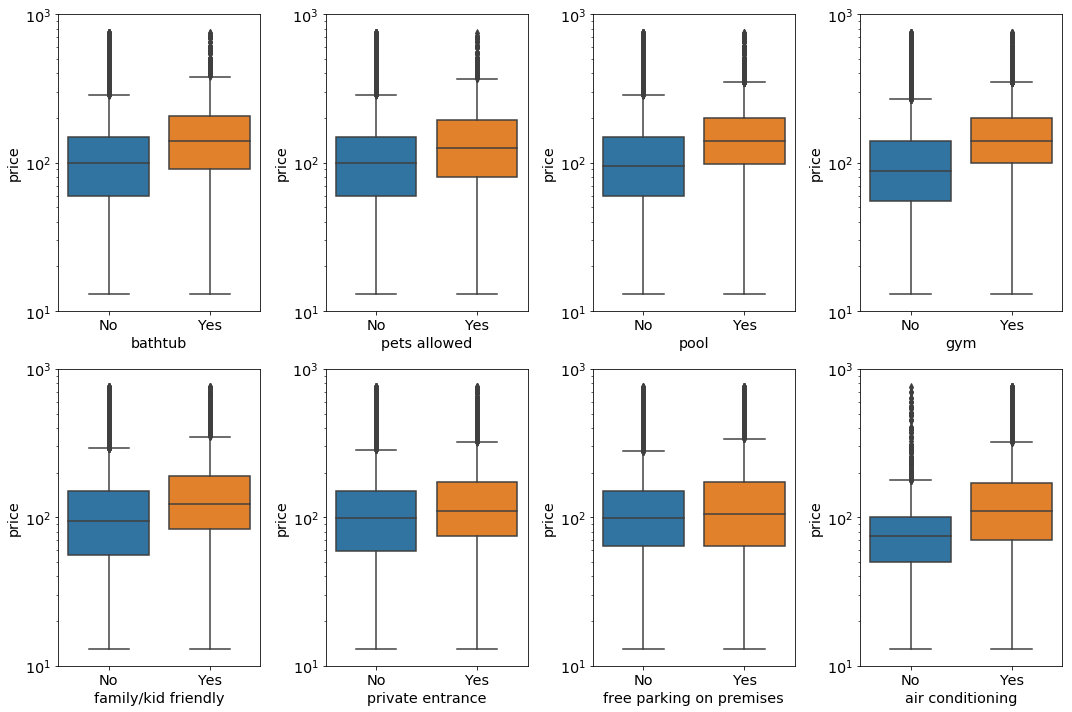

In [67]:
amenities_test = ['bathtub','pets allowed','pool','gym','family/kid friendly',
                  'private entrance', 'free parking on premises', 'air conditioning']

plt.figure(figsize=(15,10))
for i, item in enumerate(amenities_test,1):
    plt.subplot(2,4,i)
    sns.boxplot(data=df, x=item, y='price',order=[0,1])
    plt.xlabel(item)
    plt.ylabel('price')
    plt.yscale('log')
    plt.ylim([10,1000])
    plt.xticks([0,1],['No','Yes'])
plt.tight_layout()
plt.savefig(out_folder +'amenities_box.png')

## 4.4 Host Information

### 4.4.1 Superhost status

In [68]:
df.host_is_superhost.value_counts(dropna=False,normalize=True)

f          0.738074
t          0.261682
missing    0.000243
Name: host_is_superhost, dtype: float64

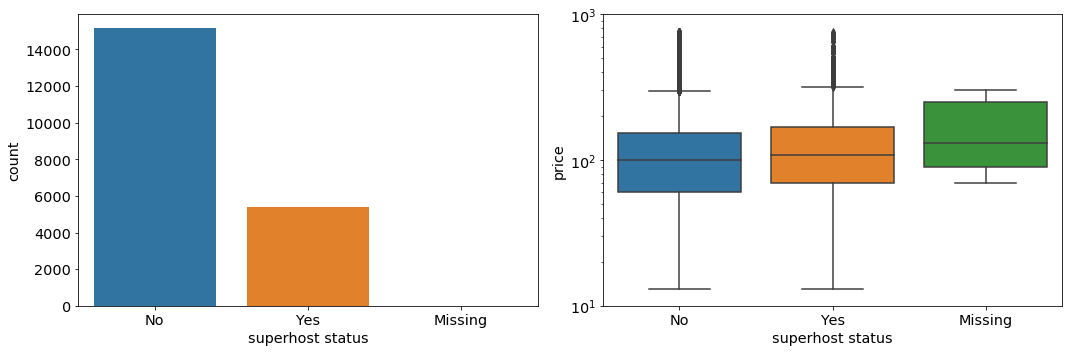

In [69]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(data=df, x='host_is_superhost')
plt.xlabel('superhost status')
plt.xticks([0,1,2],['No','Yes','Missing'])
plt.subplot(1,2,2)
sns.boxplot(data=df, x='host_is_superhost', y='price')
plt.xticks([0,1,2],['No','Yes','Missing'])
plt.xlabel('superhost status')
plt.ylabel('price')
plt.yscale('log')
plt.ylim([10,1000])
plt.tight_layout()
plt.savefig(out_folder + 'superhost_count_box.png');

## 4.5 Booking Policy

### 4.5.1 Cleaning fee

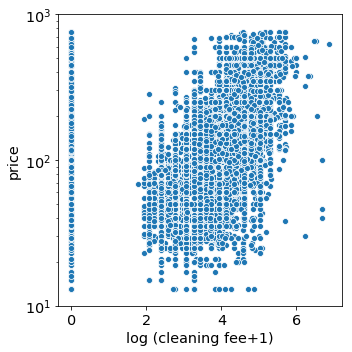

In [70]:
df['log_cleaning_fee'] = np.log(df.cleaning_fee + 1)

sns.scatterplot(x='log_cleaning_fee',y='price',data=df)
plt.xlabel('log (cleaning fee+1)')
plt.ylabel('price')
plt.yscale('log')
plt.ylim([10,1000])
plt.tight_layout()
plt.savefig(out_folder +'logcleaningfee_price')

df.drop('log_cleaning_fee',axis=1,inplace=True)

### 4.5.2 Minimum Nights of stay

In [71]:
df['minimum_nights_category'] = df.minimum_nights.apply(lambda x: "1 day" if x ==1 
                                                        else ("2 days" if x ==2 
                                                              else("3 days" if x ==3
                                                                   else ("4 to 7 days" if x <=7 
                                                                         else ">7 days"))))

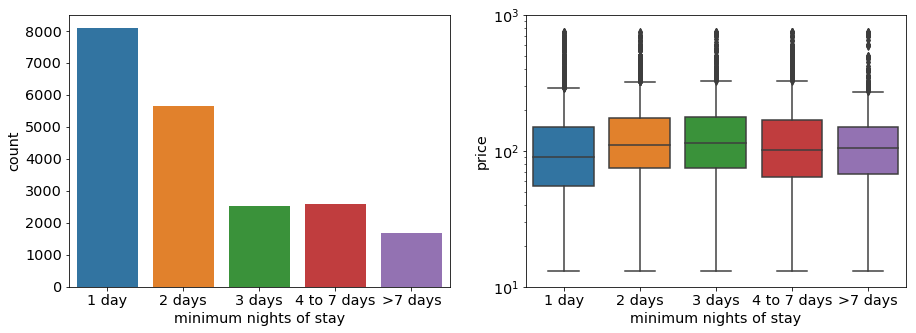

In [72]:
order = ["1 day","2 days", "3 days", "4 to 7 days", ">7 days"]
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(data=df,x='minimum_nights_category',order=order)
plt.xlabel('minimum nights of stay')
plt.subplot(1,2,2)
sns.boxplot(data=df, x='minimum_nights_category', y='price',order=order)
plt.xlabel('minimum nights of stay')
plt.ylabel('price')
plt.yscale('log')
plt.ylim([10,1000])
plt.savefig(out_folder +'min_night.png');

In [73]:
df.minimum_nights_category.value_counts(normalize=True)

1 day          0.394081
2 days         0.274971
4 to 7 days    0.125779
3 days         0.123248
>7 days        0.081922
Name: minimum_nights_category, dtype: float64

In [74]:
df.drop('minimum_nights_category',axis=1,inplace=True)

### 4.5.3 Other Numerical Features

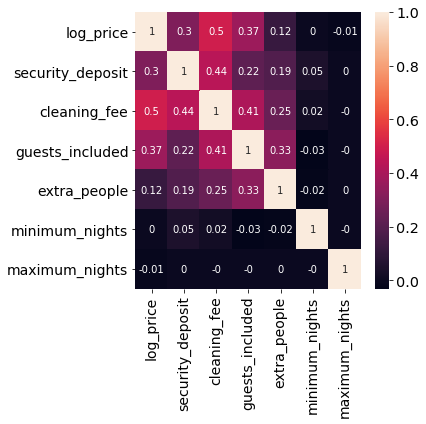

In [75]:
corr_matrix = df[['log_price','security_deposit', 'cleaning_fee','guests_included', 'extra_people',
                  'minimum_nights', 'maximum_nights']].corr().round(2)
plt.figure(figsize=(6,6))
sns.heatmap(corr_matrix, annot=True)
plt.tick_params(labelsize=14)
plt.tight_layout()
plt.savefig(out_folder + 'booking_num_corr.png');

## 4.6 Availability

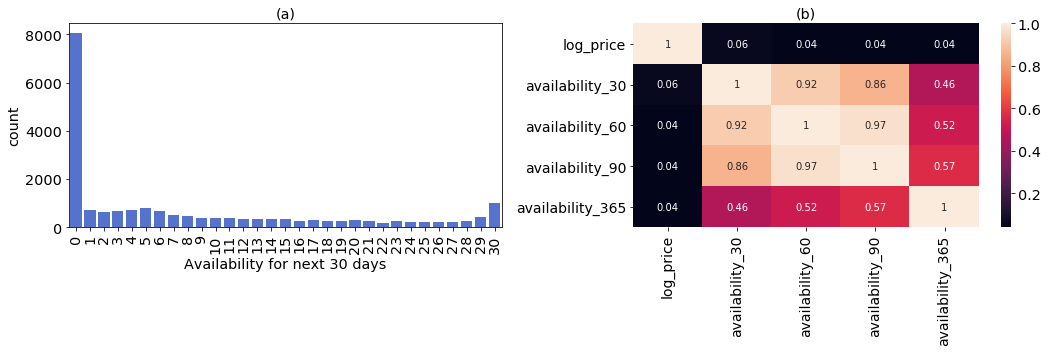

In [76]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(data=df,x='availability_30', color='royalblue')
plt.xticks(rotation=90)
plt.xlabel('Availability for next 30 days')
plt.title('(a)')
plt.subplot(1,2,2)

corr_matrix = df[['log_price','availability_30', 'availability_60', 'availability_90', 'availability_365']].corr().round(2)
sns.heatmap(corr_matrix,annot=True)
plt.tick_params(labelsize=14)
plt.title('(b)')

plt.tight_layout()
plt.savefig(out_folder + 'availibility_corr.png');

# 4.7 Reviews


In [77]:
def review_scores_rating_category(score):
    if score >=96:
        return '96 or above'
    elif score < 96 and score >= 90:
        return 'between 90 and 96'
    else: 
        return 'below 90' 

df['review_scores_rating_category'] = df['review_scores_rating'].apply(review_scores_rating_category)

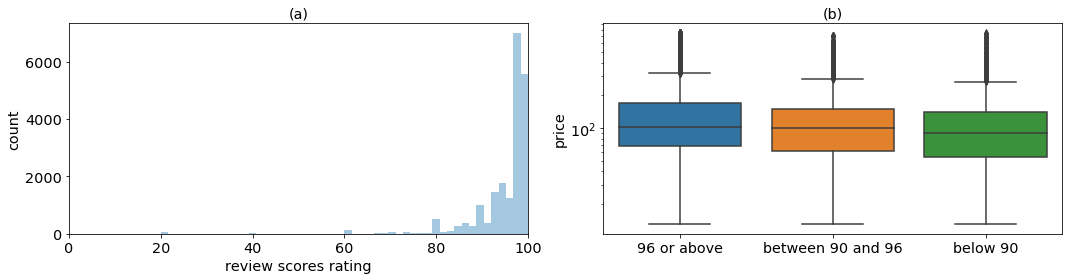

In [78]:
plt.figure(figsize=(15,4))

plt.subplot(1,2,1)
sns.distplot(df.review_scores_rating,kde=False)
plt.xlim(0,100)
plt.xlabel('review scores rating')
plt.ylabel('count')
plt.title('(a)')

plt.subplot(1,2,2)

sns.boxplot(data=df, x='review_scores_rating_category',y='price')
plt.xlabel('')
plt.ylabel('price')
plt.yscale('log')
plt.title('(b)')
plt.tight_layout()
plt.savefig(out_folder + 'review_hist_box.png')

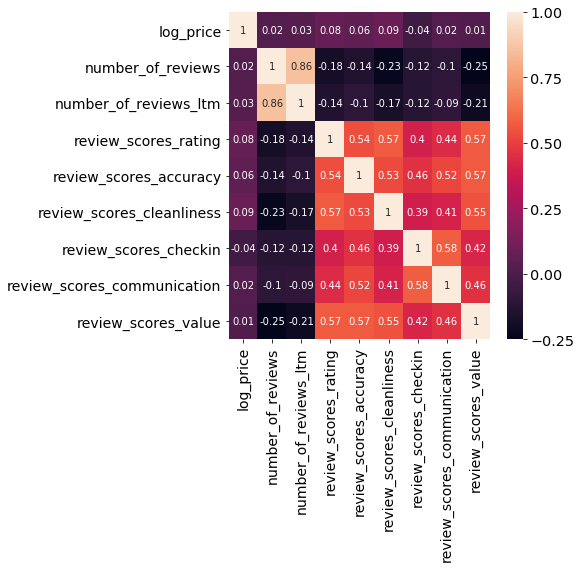

In [81]:
plt.figure(figsize=(8,8))

corr_matrix = df[['log_price','number_of_reviews','number_of_reviews_ltm','review_scores_rating', 'review_scores_accuracy', 
                  'review_scores_cleanliness','review_scores_checkin','review_scores_communication',
                  'review_scores_value']].corr(method='spearman').round(2)

sns.heatmap(corr_matrix,annot=True)
plt.tick_params(labelsize=14)
plt.tight_layout()
plt.savefig(out_folder + 'review_corr.png')

In [80]:
df.drop('review_scores_rating_category',axis=1,inplace=True)

## 4.8 Statistical Analysis of Categorical Features

In [221]:
from collections import OrderedDict

In [222]:
def pop_eval(feature_list,threshold = 20):
    category_testing_summary = pd.DataFrame(OrderedDict({'test':[], 'number of categories':[],'rejected_null_hypothesis':[]}))
    for feature in feature_list:
        filter_ = (df[feature].value_counts() > threshold)
        data_list = []
        var_str = ""
        cat_list = df[feature].value_counts()[filter_].index
        for i, cat in enumerate(cat_list):
            data_list.append(list(df.loc[df[feature] == cat, 'log_price'].values))
            var_str = var_str + 'data_list' + "[" + str(i) + "]" + ", "
        
        var_str = var_str[:-2]
        
        num_categories = len(cat_list)
        
        if num_categories > 2:
            s, p = eval('kruskal(' + var_str + ')')
            test_used = 'Kruskal-Wallis'
        elif num_categories == 2:
            s, p = eval('mannwhitneyu('+ var_str + ')')
            test_used = 'MannWhitneyU'
        print(f'Feature: {feature}')
        print(f'Categories: {list(cat_list)}')
        if num_categories ==1:
            rejected = 'NA'
            print(f'Only one category has count above the threshold of {threshold}. No test was performed.')
        elif num_categories > 2:
            print('Test: Kruskal-Wallis Test')
        elif num_categories == 2:
            print('Test: Mann Whitney U Test')
        print(f'The test statistics is {s} and the p-value is {p}.')
        if num_categories > 1:
            if p < 0.05:
                rejected = 'yes'
                print('Null hypothesis rejected. There is significant evidence the not all samples are from the same distribution.')
            else:
                print('Null hypothesis NOT rejected. There is not significant evidence the samples are not from the same distribution.')
                rejected = 'no'
            print('\n')
        category_testing_summary.loc[feature] = [test_used, num_categories, rejected]
    return category_testing_summary

In [1]:
property_type_test = pop_eval(['property_type_simple', 'room_type', 'bed_type', 'city_fsa'])

NameError: name 'pop_eval' is not defined

In [224]:
property_type_test

,test,number of categories,rejected_null_hypothesis
property_type_simple,Kruskal-Wallis,4.0,yes
room_type,Kruskal-Wallis,3.0,yes
bed_type,Kruskal-Wallis,5.0,yes
city_fsa,Kruskal-Wallis,9.0,yes


In [225]:
policy_test = pop_eval(['cancellation_policy','instant_bookable','is_business_travel_ready'])

Feature: cancellation_policy
Categories: ['strict_14_with_grace_period', 'moderate', 'flexible', 'super_strict_30']
Test: Kruskal-Wallis Test
The test statistics is 679.9027904515203 and the p-value is 4.78394048145418e-147.
Null hypothesis rejected. There is significant evidence the not all samples are from the same distribution.


Feature: instant_bookable
Categories: ['f', 't']
Test: Mann Whitney U Test
The test statistics is 45366984.5 and the p-value is 1.0586762305363768e-32.
Null hypothesis rejected. There is significant evidence the not all samples are from the same distribution.


Feature: is_business_travel_ready
Categories: ['f']
Only one category has count above the threshold of 20. No test was performed.
The test statistics is 45366984.5 and the p-value is 1.0586762305363768e-32.


In [226]:
policy_test

,test,number of categories,rejected_null_hypothesis
cancellation_policy,Kruskal-Wallis,4.0,yes
instant_bookable,MannWhitneyU,2.0,yes
is_business_travel_ready,MannWhitneyU,1.0,NA


In [227]:
host_test = pop_eval(['host_response_time', 'host_is_superhost', 'host_has_profile_pic', 'host_identity_verified'])

Feature: host_response_time
Categories: ['within an hour', 'missing', 'within a few hours', 'within a day', 'a few days or more']
Test: Kruskal-Wallis Test
The test statistics is 33.137444988405015 and the p-value is 1.1195292157122366e-06.
Null hypothesis rejected. There is significant evidence the not all samples are from the same distribution.


Feature: host_is_superhost
Categories: ['f', 't']
Test: Mann Whitney U Test
The test statistics is 37984977.0 and the p-value is 5.628342109330487e-14.
Null hypothesis rejected. There is significant evidence the not all samples are from the same distribution.


Feature: host_has_profile_pic
Categories: ['t', 'f']
Test: Mann Whitney U Test
The test statistics is 449090.0 and the p-value is 0.014781090446104315.
Null hypothesis rejected. There is significant evidence the not all samples are from the same distribution.


Feature: host_identity_verified
Categories: ['f', 't']
Test: Mann Whitney U Test
The test statistics is 47447783.0 and the p-

In [228]:
host_test

,test,number of categories,rejected_null_hypothesis
host_response_time,Kruskal-Wallis,5.0,yes
host_is_superhost,MannWhitneyU,2.0,yes
host_has_profile_pic,MannWhitneyU,2.0,yes
host_identity_verified,MannWhitneyU,2.0,yes


In [229]:
amenities_list = list(amenities_set)
lower = df.shape[0] * 0.1
upper = df.shape[0] * 0.9
filter_ = (df[amenities_list].sum() <=  upper) & (df[amenities_list].sum() >=  lower)
amenities_test = df[amenities_list].sum()[filter_].index

In [230]:
amenities_test = pop_eval(amenities_test)

Feature: elevator
Categories: [0, 1]
Test: Mann Whitney U Test
The test statistics is 31144919.5 and the p-value is 0.0.
Null hypothesis rejected. There is significant evidence the not all samples are from the same distribution.


Feature: pets allowed
Categories: [0, 1]
Test: Mann Whitney U Test
The test statistics is 18563799.0 and the p-value is 3.675148420293735e-55.
Null hypothesis rejected. There is significant evidence the not all samples are from the same distribution.


Feature: paid parking off premises
Categories: [0, 1]
Test: Mann Whitney U Test
The test statistics is 32022566.5 and the p-value is 1.762907808201996e-49.
Null hypothesis rejected. There is significant evidence the not all samples are from the same distribution.


Feature: cable tv
Categories: [0, 1]
Test: Mann Whitney U Test
The test statistics is 26288676.0 and the p-value is 2.876616590338625e-202.
Null hypothesis rejected. There is significant evidence the not all samples are from the same distribution.




Feature: private entrance
Categories: [0, 1]
Test: Mann Whitney U Test
The test statistics is 40638743.0 and the p-value is 4.477019637652956e-60.
Null hypothesis rejected. There is significant evidence the not all samples are from the same distribution.


Feature: pool
Categories: [0, 1]
Test: Mann Whitney U Test
The test statistics is 21534418.0 and the p-value is 4.3473049191694894e-207.
Null hypothesis rejected. There is significant evidence the not all samples are from the same distribution.


Feature: safety card
Categories: [0, 1]
Test: Mann Whitney U Test
The test statistics is 22006993.5 and the p-value is 7.129708059449049e-11.
Null hypothesis rejected. There is significant evidence the not all samples are from the same distribution.


Feature: coffee maker
Categories: [0, 1]
Test: Mann Whitney U Test
The test statistics is 38468774.0 and the p-value is 2.524092063818572e-116.
Null hypothesis rejected. There is significant evidence the not all samples are from the same distri

In [231]:
out_folder = '../data/interim/'
property_type_test.append(policy_test).append(host_test).append(amenities_test).to_csv(out_folder + '/categorical_test.csv')

# Data preprocessing prior to machine learning

## Change binary variables datatype from string to numeric


In [232]:
for col in ['host_is_superhost','host_has_profile_pic','host_identity_verified','is_location_exact','has_availability',
            'requires_license','instant_bookable','is_business_travel_ready','require_guest_profile_picture',
            'require_guest_phone_verification']:
    if df[col].nunique() == 2:
        df[col] = df[col].map({'t':1,'f':0})

In [233]:
for col in ['host_is_superhost','host_has_profile_pic','host_identity_verified','is_location_exact','has_availability',
            'requires_license','instant_bookable','is_business_travel_ready','require_guest_profile_picture',
            'require_guest_phone_verification']:
    print(f'{col} --> {df[col].nunique()}')

host_is_superhost --> 3
host_has_profile_pic --> 3
host_identity_verified --> 3
is_location_exact --> 2
has_availability --> 1
requires_license --> 1
instant_bookable --> 2
is_business_travel_ready --> 1
require_guest_profile_picture --> 2
require_guest_phone_verification --> 2


## Irrelevant Feature Removal 

**Excessive Missing Values**

In [234]:
features_to_remove = set()

missing_features = list(df_missing.loc[df_missing['Missing Percentage'] > 50].index)
features_to_remove.update(missing_features)

In [235]:
print(missing_features)

['notes', 'thumbnail_url', 'medium_url', 'xl_picture_url', 'host_acceptance_rate', 'neighbourhood_group_cleansed', 'square_feet', 'weekly_price', 'monthly_price', 'license', 'jurisdiction_names']


**Text Features**

In [236]:
text_features = ['name','summary','space','description','neighborhood_overview','transit','access','interaction',
                'house_rules','host_verifications']
features_to_remove.update(text_features)

**Webscraping Information**

In [237]:
webscrapping_features = ['id','scrape_id','last_scraped','calendar_last_scraped','calendar_updated']
features_to_remove.update(webscrapping_features)

**Airbnb listing information and host personal information**

In [238]:
listing_host_features = ['listing_url','thumbnail_url','medium_url','picture_url','xl_picture_url','host_id','host_url',
                         'host_name','host_location','host_about','host_thumbnail_url','host_picture_url',
                         'host_neighbourhood','host_total_listings_count']
features_to_remove.update(listing_host_features)

**Redundant information**

In [239]:
redundant_features = ['street','neighbourhood','neighbourhood_cleansed','neighbourhood_group_cleansed','city','state',
                     'zipcode','market','smart_location','country_code','country','latitude','longitude','amenities',
                      'first_review','last_review','host_since','fsa', 'property_type']
features_to_remove.update(redundant_features)

**Reference information**

In [240]:
reference_features = ['minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights',
                     'minimum_nights_avg_ntm','maximum_nights_avg_ntm','calculated_host_listings_count', 
                      'calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms', 
                      'calculated_host_listings_count_shared_rooms']
features_to_remove.update(reference_features)

**Features with single value**

In [241]:
single_value_features = []

for col in df.columns:
    if df[col].nunique() == 1:
        single_value_features.append(col)
        print(col)
features_to_remove.update(single_value_features)

scrape_id
experiences_offered
country_code
country
has_availability
requires_license
license
is_business_travel_ready


In [242]:
df.drop(features_to_remove,axis =1, inplace = True)

In [243]:
df.shape

(20544, 259)

## Create Dummy Variables

We create dummy variables for all categorical features.

In [244]:
df = pd.get_dummies(df, drop_first=False)

In [245]:
df.shape

(20544, 290)

In [246]:
to_folder = '../data/processed/'
df.to_csv(to_folder + 'df_ml.csv', index=False)

In [248]:
read_file = '../data/processed/df_ml.csv'
df2 = pd.read_csv(read_file)

(20544, 290)